# Evaluation of off-target binding of generated molecules on homologous receptors

In [1]:
import os
import sys
sys.path.append("..")  # add top folder to path

from pathlib import Path

from moses.utils import get_mol
import tinymolecule

## Data loading

In [2]:
ta = tinymolecule.TinyAnalyze()
ta.prioritize()

molecules prioritized, you can access at TinyAnalyze.priority_df


In [3]:
cross_baff = ta.priority_df

In [4]:
top_uuid = cross_baff["uuid"][:5]
top_uuid

4369    ec0fdc31
2609    e8244ede
3789    82301e56
2130    802f05ac
804     1f3586a9
Name: uuid, dtype: object

In [5]:
top_smi = []
for uuid in top_uuid:
    top_smi.append(ta.get_smiles_from_uuid(uuid))

In [6]:
top_smi

['CCCN(C(=O)OCc1ccccc1)C1CCN(CC[C@@H](CN(C)S(=O)(=O)c2ccccc2)c2ccccc2)CC1',
 'CN(C[C@@H](CCN1CCC(CCc2ccccc2)CC1)c1ccccc1)S(=O)(=O)c1ccccc1',
 'O=C(O)[C@@H](C1CCCCC1)N1C[C@H](CN2CCC(CCCCc3ccccc3)CC2)[C@@H](c2ccccc2)c1',
 'CCC(O)(C1CC2=CCCCCCCCc1cnc(Cc3ccccc3)cc1)C1CCN(C(C)C[C@@H](NC(=O)C1CCC2)c2cccc(F)c2)CC1',
 'CCn1nc(Cc2ccccc2)cc1C1CCN(C[C@H]2CN(C(=O)C3CCCC3)C[C@]2(O)c2ccccc2)CC1']

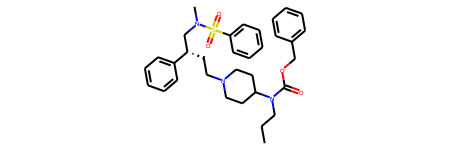

In [7]:
# 1
get_mol(top_smi[0])

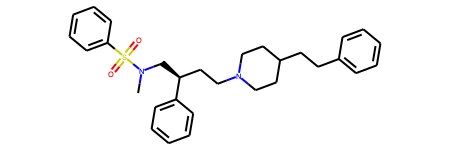

In [8]:
# 2
get_mol(top_smi[1])

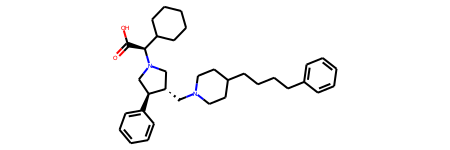

In [9]:
# 3
get_mol(top_smi[2])

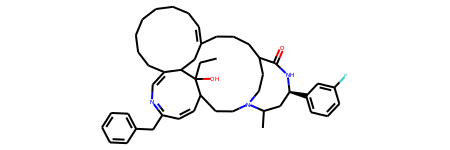

In [10]:
# 4
get_mol(top_smi[3])

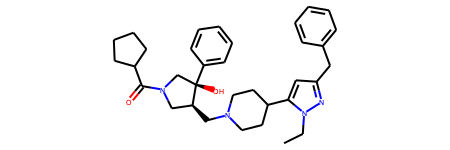

In [11]:
# 5
get_mol(top_smi[4])

In [12]:
ta.get_molecular_properties(top_uuid)

{'ec0fdc31': {'MCF_PAINS_pass': True,
  'logP': 5.994200000000007,
  'QED': 0.24949291816662938,
  'SA': 2.996830627015026,
  'weight': 577.7910000000002,
  'n_rings': 4},
 'e8244ede': {'MCF_PAINS_pass': True,
  'logP': 5.825800000000007,
  'QED': 0.3397392620058908,
  'SA': 2.6949474504507673,
  'weight': 490.71300000000025,
  'n_rings': 4},
 '82301e56': {'MCF_PAINS_pass': True,
  'logP': 6.860500000000008,
  'QED': 0.3314178880122684,
  'SA': 3.4677551581760913,
  'weight': 516.7700000000003,
  'n_rings': 5},
 '802f05ac': {'MCF_PAINS_pass': False,
  'logP': 10.229199999999999,
  'QED': 0.31110821186043863,
  'SA': 6.7262359907614835,
  'weight': 708.0189999999999,
  'n_rings': 6},
 '1f3586a9': {'MCF_PAINS_pass': True,
  'logP': 5.209600000000006,
  'QED': 0.426220213403375,
  'SA': 3.618137764509397,
  'weight': 540.7520000000003,
  'n_rings': 6}}